In [1]:
!module list


Currently Loaded Modules:
  1) anaconda3/5.1.0-gcc/8.3.1     4) cudnn/8.0.0.180-11.0-linux-x64-gcc/7.5.0
  2) anaconda3/2019.10-gcc/8.3.1   5) openjdk/1.8.0_222-b10-gcc/8.3.1
  3) cuda/11.0.3-gcc/7.5.0         6) hadoop/3.2.1-gcc/8.3.1

 



In [2]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Flatten, TimeDistributed, Dropout, LSTMCell, RNN, Bidirectional, Concatenate, Layer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.utils import tf_utils
from tensorflow.keras import backend as K

import unicodedata
import re
import os
import time
import shutil
import requests
import tarfile
import glob

import pandas as pd
import numpy as np
import string, os
tf.__version__

'2.4.0'

In [3]:
file_name = "Project_CodeNet_LangClass.tar.gz"
data_url = f"https://dax-cdn.cdn.appdomain.cloud/dax-project-codenet/1.0.0/{file_name}"

# Download tar archive to local disk
with open(file_name, "wb") as f:
    f.write(requests.get(data_url).content)
    
# Extract contents of archive to local disk
if os.path.exists("data"):
    shutil.rmtree("data")    
with tarfile.open(file_name) as tfile:
    tfile.extractall()

In [4]:
!ls data data/train

data:
test  train

data/train:
C  C#  C++  D  Haskell	Java  JavaScript  PHP  Python  Rust


In [5]:
langs = [
  "C",
  "C#",
  "C++",
  "D",
  "Haskell",
  "Java",
  "JavaScript",
  "PHP",
  "Python",
  "Rust"
]

In [6]:
import os
import argparse
import re
from tokenize import tokenize, untokenize, COMMENT, STRING, NEWLINE, ENCODING, ENDMARKER, NL, INDENT, NUMBER
from io import BytesIO
import json

lits = json.load(open("literals.json"))

def process_string(token, special_chars={" ": "U+0020", ",": "U+002C"}):
    str_quote_options = ["'''", '"""', "'", '"']
    start_quote = ""
    end_quote = ""
    qualifier_regex = r"^[a-z]+"
    qualifier_match = re.search(qualifier_regex, token)
    # string qualifiers like 'r' for regex, 'f' for formatted string, 'b' for bytes, 'u' for unicode, etc (or combination of them)
    qualifier = "" if not qualifier_match else qualifier_match[0]
    # token string without qualifiers
    token_string = re.sub(qualifier_regex, "", token)
    # string literal without quotes
    str_lit = token_string
    for q in str_quote_options:
        if token_string.startswith(q):
            start_quote = q
            str_lit = str_lit[len(q) :]
            if token_string.endswith(q):
                end_quote = q
                str_lit = str_lit[: -len(q)]
            break
    # if start_quote in str_quote_options[:2]:
    #     return ""
    for sc in special_chars:
        str_lit = str_lit.replace(sc, special_chars[sc])
    return (
        f"{qualifier}{start_quote}<STR_LIT:{str_lit}>{end_quote}"
        if str_lit in lits['str']
        else f"{qualifier}{start_quote}<STR_LIT>{end_quote}"
    )

def py_tokenize(args, file_name, file_type):
    file_paths = open(os.path.join(args.base_dir, file_name)).readlines()
    wf = open(os.path.join(args.output_dir, f"{file_type}.txt"), 'w')
    for ct,path in enumerate(file_paths):
        try:
            code = open(os.path.join(args.base_dir, path.strip())).read()
            token_gen = tokenize(BytesIO(bytes(code, "utf8")).readline)
            out_tokens = []
            prev_eol = False
            for toknum, tokval, _, _, _ in token_gen:
                tokval = " ".join(tokval.split())
                if toknum == STRING:
                    add_token = process_string(tokval)
                    out_tokens.append(add_token)
                    prev_eol = False
                elif toknum == NUMBER:
                    if tokval in lits['num']:
                        out_tokens.append(f"<NUM_LIT:{tokval}>")
                    else:
                        out_tokens.append(f"<NUM_LIT>")
                    prev_eol = False
                elif toknum in [NEWLINE, NL]:
                    if not prev_eol:
                        out_tokens.append("<EOL>")
                        prev_eol = True
                elif toknum in [COMMENT, INDENT, ENCODING, ENDMARKER] or len(tokval) == 0:
                    continue
                else:
                    out_tokens.append(tokval)
                    prev_eol = False
            if out_tokens[0] == "<EOL>":
                out_tokens = out_tokens[1:]
            if out_tokens[-1] == "<EOL>":
                out_tokens = out_tokens[:-1]
        except Exception:
            out_tokens = []
        out_tokens = ["<s>"] + out_tokens + ["</s>"]
        out = " ".join(out_tokens)
        wf.write(out+"\n")

        if ct % 10000 == 0:
            print(f"{file_type}: {ct} are done")
    wf.close()

In [7]:
file_list = glob.glob(os.path.join(os.getcwd(),"data/train/Python","*.*"))
corpus = []

for file_path in file_list:
    with open(file_path) as f_input:
        corpus.extend([line for line in f_input])
        
print(corpus[40:50])

['answermap[1] = 4\n', 'answermap[2] = 10\n', 'answermap[3] = 20\n', 'answermap[4] = 35\n', 'answermap[5] = 56\n', 'answermap[6] = 84\n', 'answermap[7] = 120\n', 'answermap[8] = 165\n', 'answermap[9] = 220\n', 'answermap[10] = 282\n']


In [8]:
def generate_dataset(): 
    output = []
    for line in corpus:
        token_list = line
        for i in range(1, len(token_list)):
            data = []
            x_ngram = '<start> '+ token_list[:i+1] + ' <end>'
            y_ngram = '<start> '+ token_list[i+1:] + ' <end>'
            data.append(x_ngram)
            data.append(y_ngram)
            output.append(data)
    print("Dataset prepared with prefix and suffixes for teacher forcing technique")
    dummy_df = pd.DataFrame(output, columns=['input','output'])
    return output, dummy_df     

class LanguageIndex():
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
    def create_index(self):
        for phrase in self.lang:
            self.vocab.update(phrase.split(' '))
        self.vocab = sorted(self.vocab)
        self.word2idx["<pad>"] = 0
        self.idx2word[0] = "<pad>"
        for i,word in enumerate(self.vocab):
            self.word2idx[word] = i + 1
            self.idx2word[i+1] = word

def max_length(t):
    return max(len(i) for i in t)

def load_dataset():
    pairs,df = generate_dataset()
    out_lang = LanguageIndex(sp for en, sp in pairs)
    in_lang = LanguageIndex(en for en, sp in pairs)
    input_data = [[in_lang.word2idx[s] for s in en.split(' ')] for en, sp in pairs]
    output_data = [[out_lang.word2idx[s] for s in sp.split(' ')] for en, sp in pairs]

    max_length_in, max_length_out = max_length(input_data), max_length(output_data)
    input_data = tf.keras.preprocessing.sequence.pad_sequences(input_data, maxlen=max_length_in, padding="post")
    output_data = tf.keras.preprocessing.sequence.pad_sequences(output_data, maxlen=max_length_out, padding="post")
    return input_data, output_data, in_lang, out_lang, max_length_in, max_length_out, df

In [9]:
input_data, teacher_data, input_lang, target_lang, len_input, len_target, df = load_dataset()

Dataset prepared with prefix and suffixes for teacher forcing technique


In [10]:
target_data = [[teacher_data[n][i+1] for i in range(len(teacher_data[n])-1)] for n in range(len(teacher_data))]
target_data = tf.keras.preprocessing.sequence.pad_sequences(target_data, maxlen=len_target, padding="post")
target_data = target_data.reshape((target_data.shape[0], target_data.shape[1], 1))

# Shuffle all of the data in unison. This training set has the longest (e.g. most complicated) data at the end,
# so a simple Keras validation split will be problematic if not shuffled.

p = np.random.permutation(len(input_data))
input_data = input_data[p]
teacher_data = teacher_data[p]
target_data = target_data[p]

In [11]:
pd.set_option('display.max_colwidth', -1)
BUFFER_SIZE = len(input_data)
BATCH_SIZE = 128
embedding_dim = 300
units = 128
vocab_in_size = len(input_lang.word2idx)
vocab_out_size = len(target_lang.word2idx)
df.describe()

,input,output
count,124023,124023
unique,57347,63763
top,<start> <end>,<start> <end>
freq,3254,4424


In [12]:
# Create the Encoder layers first.
encoder_inputs = Input(shape=(len_input,))
encoder_emb = Embedding(input_dim=vocab_in_size, output_dim=embedding_dim)

# Use this if you dont need Bidirectional LSTM
# encoder_lstm = CuDNNLSTM(units=units, return_sequences=True, return_state=True)
# encoder_out, state_h, state_c = encoder_lstm(encoder_emb(encoder_inputs))

encoder_lstm = Bidirectional(LSTM(units=units, return_sequences=True, return_state=True))
encoder_out, fstate_h, fstate_c, bstate_h, bstate_c = encoder_lstm(encoder_emb(encoder_inputs))
state_h = Concatenate()([fstate_h,bstate_h])
state_c = Concatenate()([bstate_h,bstate_c])
encoder_states = [state_h, state_c]


# Now create the Decoder layers.
decoder_inputs = Input(shape=(None,))
decoder_emb = Embedding(input_dim=vocab_out_size, output_dim=embedding_dim)
decoder_lstm = LSTM(units=units*2, return_sequences=True, return_state=True)
decoder_lstm_out, _, _ = decoder_lstm(decoder_emb(decoder_inputs), initial_state=encoder_states)
# Two dense layers added to this model to improve inference capabilities.
decoder_d1 = Dense(units, activation="relu")
decoder_d2 = Dense(vocab_out_size, activation="softmax")
decoder_out = decoder_d2(Dropout(rate=.2)(decoder_d1(Dropout(rate=.2)(decoder_lstm_out))))


# Finally, create a training model which combines the encoder and the decoder.
# Note that this model has three inputs:
model = Model(inputs = [encoder_inputs, decoder_inputs], outputs= decoder_out)

# We'll use sparse_categorical_crossentropy so we don't have to expand decoder_out into a massive one-hot array.
# Adam is used because it's, well, the best.

model.compile(optimizer=tf.optimizers.Adam(), loss="sparse_categorical_crossentropy", metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 231)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 231, 300)     6453600     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 231, 256), ( 439296      embedding[0][0]                  
______________________________________________________________________________________________

In [14]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [15]:
epochs = 10
history = model.fit([input_data, teacher_data], target_data,
                 batch_size= BATCH_SIZE,
                 epochs=epochs,
                 validation_split=0.2,
                 callbacks=callbacks_list)

Epoch 1/10
776/776 [==============================] - 1568s 2s/step - loss: 0.1196 - sparse_categorical_accuracy: 0.9839 - val_loss: 0.0873 - val_sparse_categorical_accuracy: 0.9873

Epoch 00001: loss improved from inf to 0.11961, saving model to model.h5
Epoch 2/10
776/776 [==============================] - 1599s 2s/step - loss: 0.0771 - sparse_categorical_accuracy: 0.9884 - val_loss: 0.0649 - val_sparse_categorical_accuracy: 0.9904

Epoch 00002: loss improved from 0.11961 to 0.07710, saving model to model.h5
Epoch 3/10
776/776 [==============================] - 1566s 2s/step - loss: 0.0612 - sparse_categorical_accuracy: 0.9904 - val_loss: 0.0546 - val_sparse_categorical_accuracy: 0.9916

Epoch 00003: loss improved from 0.07710 to 0.06120, saving model to model.h5
Epoch 4/10
776/776 [==============================] - 1564s 2s/step - loss: 0.0517 - sparse_categorical_accuracy: 0.9916 - val_loss: 0.0479 - val_sparse_categorical_accuracy: 0.9924

Epoch 00004: loss improved from 0.06120 t

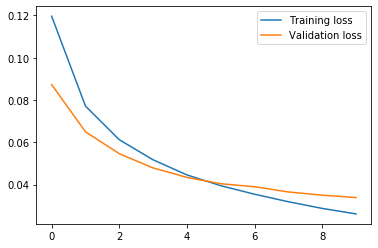

In [17]:
# Plot the results of the training.
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend()
plt.show()

In [18]:
# Create the encoder model from the tensors we previously declared.
encoder_model = Model(encoder_inputs, [encoder_out, state_h, state_c])

# Generate a new set of tensors for our new inference decoder. Note that we are using new tensors, 
# this does not preclude using the same underlying layers that we trained on. (e.g. weights/biases).

inf_decoder_inputs = Input(shape=(None,), name="inf_decoder_inputs")
# We'll need to force feed the two state variables into the decoder each step.
state_input_h = Input(shape=(units*2,), name="state_input_h")
state_input_c = Input(shape=(units*2,), name="state_input_c")
decoder_res, decoder_h, decoder_c = decoder_lstm(
    decoder_emb(inf_decoder_inputs), 
    initial_state=[state_input_h, state_input_c])
inf_decoder_out = decoder_d2(decoder_d1(decoder_res))
inf_model = Model(inputs=[inf_decoder_inputs, state_input_h, state_input_c], 
                  outputs=[inf_decoder_out, decoder_h, decoder_c])

In [19]:
# Converts the given sentence (just a string) into a vector of word IDs
# Output is 1-D: [timesteps/words]

def sentence_to_vector(sentence, lang):

    pre = sentence
    vec = np.zeros(len_input)
    sentence_list = [lang.word2idx[s] for s in pre.split(' ')]
    for i,w in enumerate(sentence_list):
        vec[i] = w
    return vec

# Given an input string, an encoder model (infenc_model) and a decoder model (infmodel),
def translate(input_sentence, infenc_model, infmodel):
    sv = sentence_to_vector(input_sentence, input_lang)
    sv = sv.reshape(1,len(sv))
    [emb_out, sh, sc] = infenc_model.predict(x=sv)
    
    i = 0
    start_vec = target_lang.word2idx["<start>"]
    stop_vec = target_lang.word2idx["<end>"]
    
    cur_vec = np.zeros((1,1))
    cur_vec[0,0] = start_vec
    cur_word = "<start>"
    output_sentence = ""

    while cur_word != "<end>" and i < (len_target-1):
        i += 1
        if cur_word != "<start>":
            output_sentence = output_sentence + " " + cur_word
        x_in = [cur_vec, sh, sc]
        [nvec, sh, sc] = infmodel.predict(x=x_in)
        cur_vec[0,0] = np.argmax(nvec[0,0])
        cur_word = target_lang.idx2word[np.argmax(nvec[0,0])]
    return output_sentence

In [26]:
test = [
    'for',
    'for i in range',
    'if',
    'import ',
    'import math',
    'import ma'
]
  

import pandas as pd
output = []  
for t in test:  
  output.append({"Input seq":t.lower(), "Pred. Seq":translate(t.lower(), encoder_model, inf_model)})

results_df = pd.DataFrame.from_dict(output) 
results_df.head(len(test))

,Input seq,Pred. Seq
0,for,the Sample Input\n
1,for i in range,(n):\n
2,if,import bisect_left\n
3,import,v2: list)->float:\n
4,import math,utf-8 -*-\n
5,import ma,"}"".format(R*R*math.pi,R*2*math.pi))\n"
